### Loading Data and Packages

In [17]:
#Import necessary libraries
import pandas as pd
import matplotlib as plt
import numpy as np
import sqlite3
import datetime
import matplotlib.pyplot as pyplot
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data

In [2]:
#Import Data
tx_data=pd.read_csv("UCI_online/data.csv")
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
# Establish connection with internal db
con = sqlite3.connect('UCI.db')
cursor = con.cursor()
# Drop tables that already exist by running the following commands
cursor.executescript("DROP TABLE IF EXISTS transactions")

In [4]:
# import data to db
tx_data.to_sql('transactions', con, if_exists="replace")

In [5]:
# verify that all data are loaded to the database
# transactions = pd.read_sql('SELECT * FROM transactions', con)
# transactions.head(n=10)

### Data Cleaning and Exploratory Data Analysis 

Some basic analysis from the transaction dataset.

In [6]:
# Number of unique for each column
tx_data.nunique(axis=0)

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

#### We want to look at the trend of number of transactions and the total amount in value over all dates.

In [7]:
# Make a copy of the original dataset.
tx_keep_date = tx_data.copy()
    
# Extract date from datetime
tx_keep_date['InvoiceDate'] = pd.to_datetime(tx_keep_date['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date

# days from first date
tx_keep_date['days_from_first'] = (tx_keep_date['InvoiceDate'] - tx_keep_date['InvoiceDate'].min()).dt.days

# Into database
tx_keep_date.to_sql("tx_keep_date", con, if_exists="replace")

In [8]:
sql1 = """
SELECT days_from_first, SUM(Quantity*UnitPrice) AS value, COUNT(*) AS orders 
FROM tx_keep_date
GROUP BY days_from_first
ORDER BY days_from_first
"""
sql1_df = pd.read_sql(sql1, con)

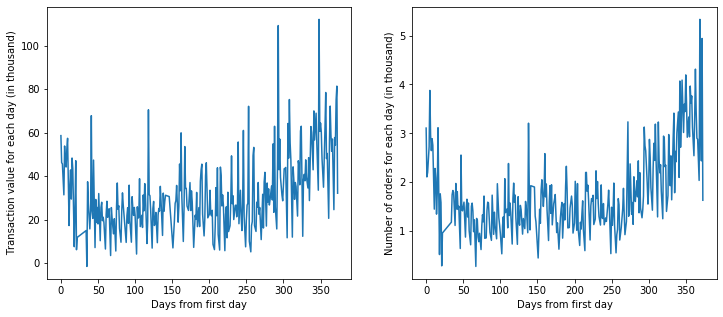

In [9]:
days_from_first = np.array(sql1_df['days_from_first'])
value_each_day = np.array(sql1_df['value'])
orders_each_day = np.array(sql1_df['orders'])
assert len(days_from_first)==len(value_each_day)==len(orders_each_day)

pyplot.figure(figsize=(12, 5))
pyplot.subplot(121)
pyplot.plot(days_from_first, value_each_day/1000)
pyplot.xlabel("Days from first day")
pyplot.ylabel("Transaction value for each day (in thousand)")
pyplot.subplot(122)
pyplot.plot(days_from_first, orders_each_day/1000)
pyplot.xlabel("Days from first day")
pyplot.ylabel("Number of orders for each day (in thousand)")
pyplot.show()

There is an obvious upward trend in October, November 2011. Our estimate for the holdout period might be underestimating the money value and frecuency with our model.

#### We aggregate transaction data by customerID. We are particularly interested in the distribution of the frequncy of customers. Most of them who make repeat purchase 

In [10]:
sql2 = """
SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value, 
SUM(Quantity*UnitPrice)/COUNT(*) AS money_value, COUNT(*) AS frequency
FROM transactions
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID 
HAVING COUNT(*) > 0 AND total_value > 0
ORDER BY COUNT(*) DESC
"""
sql2_df = pd.read_sql(sql2, con)
sql2_df.head(n=10)

,CustomerID,total_value,money_value,frequency
0,17841.0,40340.78,5.053336,7983
1,14911.0,132572.62,22.458516,5903
2,14096.0,57120.91,11.139023,5128
3,12748.0,29072.10,6.262839,4642
4,14606.0,11713.85,4.210586,2782
5,15311.0,59419.34,23.853609,2491
6,14646.0,279489.02,134.047492,2085
7,13089.0,57385.88,30.902466,1857
8,13263.0,7454.07,4.444884,1677
9,14298.0,50862.44,31.013683,1640


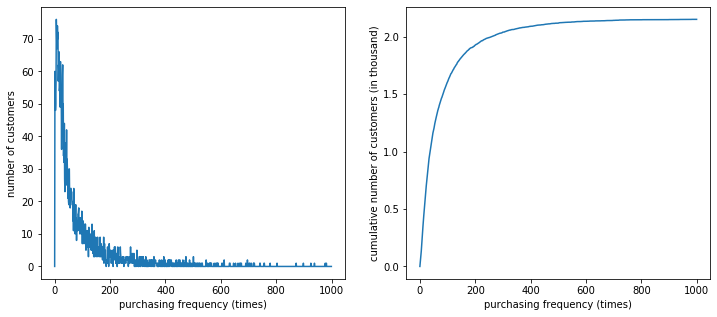

In [11]:
# the distribution of # of transactions per customer (<1000)
customer_times_vector = np.array(sql2_df['frequency'])
count_vector = [np.sum(customer_times_vector==i) for i in range(8000)]

pyplot.figure(figsize=(12, 5))
pyplot.subplot(121)
pyplot.plot(range(1000), count_vector[:1000])
pyplot.xlabel("purchasing frequency (times)")
pyplot.ylabel("number of customers")
pyplot.subplot(122)
pyplot.plot(range(1000), np.cumsum(count_vector)[:1000]/2000)
pyplot.xlabel("purchasing frequency (times)")
pyplot.ylabel("cumulative number of customers (in thousand)")
pyplot.show()

For all models, the following nomenclature is used:

• frequency represents the number of repeat purchases the customer has made. This means that it’s one less
than the total number of purchases. This is actually slightly wrong. <span style="color:red"> It’s the count of time periods the customer had a purchase in</span>. So if using days as units, then it’s the count of days the customer had a purchase on.

• T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal
to the duration between a customer’s first purchase and the end of the period under study.

• recency represents the age of the customer when they made their most recent purchases. This is equal to the
duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase,
the recency is 0.)

• monetary_value represents the average value of a given customer’s purchases. This is equal to the sum of
all a customer’s purchases divided by the total number of purchases. <span style="color:red">Note that the denominator here is different than the frequency described above</span>.

### Data Prepocessing
An important note: <span style="color:red">Calibration period ends 2011-08-31 (default, can be changed below).</span>

Two options to get the data in required format:
1. Call "cal_holdout" function that is defined below (for faster speed and extra attributes)
2. Call the built in "summary_cal_holdout" from the lifetimes package.

Note that the two options result in slightly different parameter estimates because the "cal_holdout" function filters out negative transactions.

In [12]:
def all_customers(original_data_frame = None) -> pd:
    """
    takes the original csv dataset read
    leaves out transactions with negative amount
    
    returns a pandas dataframe that contains the following columns:
    CustomerID, total_value, latest_purchase_date, first_purchase_date, monetary_value_per_purchase, frequecy_day
    """
    # Make a copy of the original dataset.
    tx_keep_date = tx_data.copy()
    # Extract date from datetime
    tx_keep_date['InvoiceDate'] = pd.to_datetime(tx_keep_date['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date
    # Import the training data into db
    tx_keep_date.to_sql("tx_keep_date", con=con, if_exists="replace")
    sql = """
    SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value, 
    MAX(InvoiceDate) AS latest, MIN(InvoiceDate) AS first, 
    SUM(Quantity*UnitPrice)/COUNT(*) AS monetary_value, CASE WHEN COUNT(DISTINCT InvoiceDate)-1 < 0 THEN 0 ELSE COUNT(DISTINCT InvoiceDate)-1 END AS frequency
    FROM tx_keep_date
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID 
    HAVING COUNT(DISTINCT InvoiceDate) >= 0 AND total_value >= 0
    ORDER BY COUNT(DISTINCT InvoiceDate) DESC
    """
    all_customers_df = pd.read_sql(sql, con)
    return all_customers_df

In [13]:
def cal_holdout(original_data_frame = None, cal_end_date = "2011-08-31") -> pd:
    """
    takes the original csv dataset read and the last day of calibration period.
    leaves out transactions with negative amount
    
    
    returns a pandas dataframe with columns:
    
    CustomerID (primary index),
    total_value_cal (total value of this customer during the calibration period, 0 if no purchase),
    first_within_cal (date of first purchase in the calibration period),
    latest_within_cal (date of latest purchase in the calibration period),
    monetary_value_cal (average value of each transaction in the calibration period, 0 if no purchase),
    frequency_cal (number of repeat purchase in the calibration period),
    recency_cal (time interval in days from the last purchase to the first),
    T_cal (time interval in days from the end of cal period to the first purchase),
    frequency_holdout (number of repeat purchase in the holdout period),
    total_value_holdout (total value of this customer in the holdout period, 0 if no purchase),
    monetary_value_holdout (average value of each transaction in the holdout period, 0 if no purchase),
    duration_holdout (duration in days of holdout period)
    """
    # Make a copy of the original dataset.
    tx_keep_date = tx_data.copy()
    
    # Extract date from datetime
    tx_keep_date['InvoiceDate'] = pd.to_datetime(tx_keep_date['InvoiceDate'], format='%m/%d/%y %H:%M').dt.date
    
    # Extract all the records whose transaction date is within calibration period.
    cal_df = tx_keep_date[tx_keep_date['InvoiceDate'] <= datetime.date.fromisoformat(cal_end_date)]
    # The rest as holdout
    hold_df = tx_keep_date[tx_keep_date['InvoiceDate'] > datetime.date.fromisoformat(cal_end_date)]
    
    # Use the latest record in holdout to calculate duration_holdout
    latest_holdout = hold_df['InvoiceDate'].max()
    duration_holdout = (latest_holdout - datetime.date.fromisoformat(cal_end_date)).days
    
    # Export pandas df to db
    cal_df.to_sql("cal", con, if_exists="replace")
    hold_df.to_sql("hold", con, if_exists="replace")
    
    sql = f"""
    SELECT c.CustomerID, c.total_value_cal, c.first_within_cal, c.latest_within_cal, 
    c.monetary_value_cal, c.frequency_cal, julianday(c.latest_within_cal)-julianday(c.first_within_cal) AS recency_cal,
    julianday('{cal_end_date}')-julianday(c.first_within_cal) AS T_cal,
    IFNULL(h.frequency_hold,'0') AS frequency_holdout, IFNULL(h.total_value_hold, '0') AS total_value_holdout, 
    IFNULL(h.monetary_value_hold,'0') AS monetary_value_holdout, {duration_holdout} AS duration_holdout
    FROM
    (SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value_cal, 
    MAX(InvoiceDate) AS latest_within_cal, MIN(InvoiceDate) AS first_within_cal, 
    SUM(Quantity*UnitPrice)/COUNT(*) AS monetary_value_cal, 
    CASE WHEN COUNT(DISTINCT InvoiceDate)-1 < 0 THEN 0 ELSE COUNT(DISTINCT InvoiceDate)-1 END AS frequency_cal
    FROM cal
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID 
    HAVING COUNT(DISTINCT InvoiceDate) >= 0 AND total_value_cal >= 0) c
    LEFT JOIN 
    (SELECT CustomerID, SUM(Quantity*UnitPrice) AS total_value_hold,
    SUM(Quantity*UnitPrice)/COUNT(*) AS monetary_value_hold, 
    CASE WHEN COUNT(DISTINCT InvoiceDate)-1 < 0 THEN 0 ELSE COUNT(DISTINCT InvoiceDate)-1 END AS frequency_hold
    FROM hold
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID
    HAVING COUNT(DISTINCT InvoiceDate) >= 0 AND total_value_hold >= 0) h
    ON c.CustomerID = h.CustomerID
    ORDER BY c.CustomerID
    
    """
    cal_hold_df = pd.read_sql(sql, con)
    cal_hold_df.set_index('CustomerID', inplace=True, drop=True)
    return cal_hold_df

In [14]:
# Option 1: Using cal_holdout function
cal_hold_df = cal_holdout(tx_data)
cal_hold_df.head()

,total_value_cal,first_within_cal,latest_within_cal,monetary_value_cal,frequency_cal,recency_cal,T_cal,frequency_holdout,total_value_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,,,,,
12346.0,0.00,2011-01-18,2011-01-18,0.000000,0,0.0,225.0,0,0,0,100
12347.0,2790.86,2010-12-07,2011-08-02,22.506935,4,238.0,267.0,1,1519.14,26.1921,100
12348.0,1487.24,2010-12-16,2011-04-05,53.115714,2,110.0,258.0,0,310,103.333,100
12350.0,334.40,2011-02-02,2011-02-02,19.670588,0,0.0,210.0,0,0,0,100
12352.0,601.18,2011-02-16,2011-03-22,12.524583,3,34.0,196.0,2,944.23,20.09,100


In [15]:
bgf1 = BetaGeoFitter(penalizer_coef=0.0)
bgf1.fit(cal_hold_df['frequency_cal'], cal_hold_df['recency_cal'], cal_hold_df['T_cal'])
bgf1.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.765950,0.029308,0.708507,0.823393
alpha,51.506173,2.417152,46.768555,56.243791
a,0.051438,0.015276,0.021498,0.081378
b,0.756857,0.270625,0.226431,1.287283


In [18]:
# Option 2: Using the built-in summary_cal_holdout function (which takes longer time)

# similar API to scikit-learn and lifelines.
summary_cal_holdout = calibration_and_holdout_data(tx_keep_date, 'CustomerID', 'InvoiceDate',
calibration_period_end='2011-08-31',
observation_period_end='2011-12-09' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,225.0,0.0,100.0
12347.0,4.0,238.0,267.0,2.0,100.0
12348.0,2.0,110.0,258.0,1.0,100.0
12350.0,0.0,0.0,210.0,0.0,100.0
12352.0,3.0,34.0,196.0,3.0,100.0


In [19]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.742604,0.028175,0.687382,0.797826
alpha,50.626912,2.371005,45.979743,55.274082
a,0.053138,0.015486,0.022786,0.083491
b,0.772902,0.271657,0.240455,1.305349
